In [2]:
import uproot
import h5py    
import numpy as np
import awkward as ak
from tqdm import tqdm
import h5py
import matplotlib.pyplot as plt
from scipy.stats import moyal, norm
from scipy import optimize
from collections import defaultdict

In [3]:
# Sum of a Landau distribution and a gaussian distribution, currently not use.
def langau(x, lan_loc, lan_scale, gau_loc, gau_scale):
    lan_y = (x-lan_loc)/lan_scale
    gau_y = (x-gau_loc)/gau_scale
    return np.exp(-(lan_y+np.exp(-lan_y))/2)/np.sqrt(2*np.pi)/lan_scale + np.exp(-gau_y**2/2)/np.sqrt(2*np.pi)/gau_scale

In [4]:
# Load the data from the root files created by the KLFitter. klf_param8 is the best reconstructed top mass fitted.
dic = defaultdict(list)
for jet_number in range(4, 9):
    file = uproot.open("/KLFitter/build/top-{}jets-output.root".format(jet_number))
    max_index = np.argmax(np.stack(file['KLFitter_output']['klf_loglikelihood'].arrays(library="np")['klf_loglikelihood']), axis=1, keepdims=True)
    for target in ['klf_lquark1_pt', 'klf_lquark1_eta', 'klf_lquark1_phi', 'klf_lquark1_e',
                   'klf_lquark2_pt', 'klf_lquark2_eta', 'klf_lquark2_phi', 'klf_lquark2_e', 'klf_param8', 'klf_bhad_pt', 'klf_blep_pt']:
        arr = np.stack(file['KLFitter_output'][target].arrays(library="np")[target])
        arr = np.take_along_axis(arr, max_index, axis=1).flatten()
        dic[target].extend(arr)

for key in dic: dic[key] = np.array(dic[key])

In [5]:
#Reconstruct the hadronic W mass and the Rbq.

# px = pt*cos(phi)
# py = pt*sin(phi)
# pz = pt*sinh(eta)
dic['px1'] = dic['klf_lquark1_pt']*np.cos(dic['klf_lquark1_phi'])
dic['py1'] = dic['klf_lquark1_pt']*np.sin(dic['klf_lquark1_phi'])
dic['pz1'] = dic['klf_lquark1_pt']*np.sinh(dic['klf_lquark1_eta'])

dic['px2'] = dic['klf_lquark2_pt']*np.cos(dic['klf_lquark2_phi'])
dic['py2'] = dic['klf_lquark2_pt']*np.sin(dic['klf_lquark2_phi'])
dic['pz2'] = dic['klf_lquark2_pt']*np.sinh(dic['klf_lquark2_eta'])

# M = sqrt((E1+E2)**2 - (px1+px2)**2 - (py1+py2)**2 - (pz1+pz2)**2)
dic['reconstructed_W_mass'] = np.sqrt((dic['klf_lquark1_e']+dic['klf_lquark2_e'])**2
                 - (dic['px1']+dic['px2'])**2
                 - (dic['py1']+dic['py2'])**2
                 - (dic['pz1']+dic['pz2'])**2)


"""
For events with two or more b-tagged jets, R reco bq is defined as the scalar sum of the transverse momenta of the b-tagged jets assigned
to the leptonically and hadronically decaying top quarks divided by the scalar sum of the transverse
momenta of the two jets associated with the hadronic W boson decay.
"""

dic['reconstructed_R_bq'] = (dic['klf_bhad_pt'] + dic['klf_blep_pt'])/(dic['klf_lquark1_pt'] + dic['klf_lquark2_pt'])

In [6]:
"""
cuts
130 < reco_m_top < 220
55 < reco_m_W < 110
0.3 < reco_R_bq < 3.0
"""

cut1 = np.logical_and(dic['klf_param8'] < 220, dic['klf_param8'] > 130)
cut2 = np.logical_and(dic['reconstructed_W_mass'] < 110, dic['reconstructed_W_mass'] > 55)
cut3 = np.logical_and(dic['reconstructed_R_bq'] < 3.0, dic['reconstructed_R_bq'] > 0.3)
cuts = np.logical_and(np.logical_and(cut1, cut2), cut3)

In [7]:
# The number of events that pass through the cut.
print('Events before cut: ', len(dic['klf_param8']))
print('reco_m_top cut: ', np.count_nonzero(cut1))
print('reco_m_W cut: ', np.count_nonzero(cut2))
print('reco_R_bq cut: ', np.count_nonzero(cut3))
print('cuts', np.count_nonzero(cuts))
for key in dic: dic[key] = dic[key][cuts]

Events before cut:  643622
reco_m_top cut:  430124
reco_m_W cut:  557831
reco_R_bq cut:  620164
cuts 404087


In [8]:
colors = ['green', 'red', 'red', 'green']

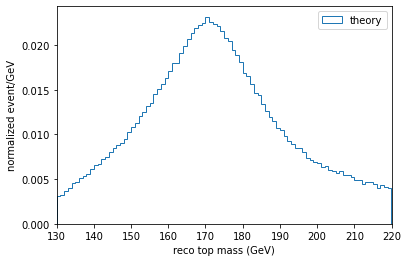

In [9]:
n, bins, patches = plt.hist(dic['klf_param8'],bins=90, density=True, histtype='step', label='theory')
plt.xlim(130, 220)
plt.xlabel('reco top mass (GeV)')
plt.ylabel('normalized event/GeV')
plt.legend()
plt.show()

170.49989538484905

Best fit top mass:  170.49989538484905
156.49995472847436
157.499950489644
158.4999462508136
159.49994201198322
160.49993777315285
161.49993353432245
162.49992929549208
163.4999250566617
164.4999208178313
165.49991657900094
166.49991234017057
167.4999081013402
168.49990386250983
169.49989962367943
170.49989538484905
171.49989114601868
172.49988690718828
173.4998826683579
174.49987842952754
175.49987419069714
176.49986995186677
177.4998657130364
178.49986147420603
179.49985723537566
180.49985299654526
181.4998487577149
182.49984451888452
183.49984028005412
184.49983604122374


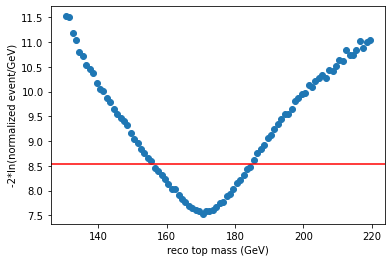

In [25]:
loglikelihood = -2*np.log(n)
plt.scatter(bins[:90]+0.5, loglikelihood)
plt.axhline(min(loglikelihood)+1, c='r')
print('Best fit top mass: ', bins[np.argmin(loglikelihood)]+0.5)
for i, value in enumerate(loglikelihood):
    if value < min(loglikelihood)+1:
        print(bins[i]+0.5)
plt.xlabel('reco top mass (GeV)')
plt.ylabel('-2*ln(normalized event/GeV)')
plt.show()

In [14]:
# plt.scatter(bins[:90]+0.5, np.log(n))
# plt.axhline(max(np.log(n))-0.5, c='r')
# for i, value in enumerate(np.log(n)):
#     if value > max(np.log(n))-0.5:
#         print(bins[i]+0.5)
# plt.xlabel('reco top mass (GeV)')
# plt.ylabel('ln(normalized event/GeV)')
# plt.legend()
# plt.show()

In [11]:
# plt.hist(dic['reconstructed_W_mass'], bins=100, density=True, histtype='step')
# arr = sorted(dic['reconstructed_W_mass'])
# for i, num in enumerate([2.28, 15.87, 84.23, 97.72]):
#     value = arr[int(len(arr)*num/100)]
#     print('precentage accumulated: ', num, 'value: ', value)
#     plt.axvline(value, c=colors[i])
# plt.xlim(55, 110)
# plt.xlabel('reco hadronic W mass (GeV)')
# plt.ylabel('normalized event/GeV')
# plt.show()

In [12]:
# plt.hist(dic['reconstructed_R_bq'], bins=100, density=True, histtype='step')
# arr = sorted(dic['reconstructed_R_bq'])
# for i, num in enumerate([2.28, 15.87, 84.23, 97.72]):
#     value = arr[int(len(arr)*num/100)]
#     print('precentage accumulated: ', num, 'value: ', value)
#     plt.axvline(value, c=colors[i])
# plt.xlim(0.3, 3.0)
# plt.xlabel('reconstructed_R_bq')
# plt.ylabel('normalized event/GeV')
# plt.show()